In [ ]:
import numpy as np
import seaborn as sb
import pandas
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston, fetch_mldata
from sklearn.linear_model import LinearRegression, RidgeClassifierCV
import sys
import time
from skimage import data, io, filters
# yes, I know - this is the installation of the github version of the nnet package on my computer
# it may and will probably vary on your's
sys.path.append("/usr/local/lib/python3.5/site-packages/nnet-0.1-py3.5-macosx-10.9-x86_64.egg")
import nnet
%matplotlib notebook

# On convolution

Before we dive into Convolutional Nets, let's check convolution itself. 

In the following we investigate a few convolution kernels, or filters, and their effect on a picture when you use them for convolution.

In [ ]:
mandrill = io.imread('data/mandrill_male.jpg',as_grey=True)

fig,ax = plt.subplots(figsize=(10,5))
io.imshow(mandrill)
plt.grid('off')

The following code implements convolution in the most unoptimized, but clear-to-read way. It cuts out patches of appropriate filter size from a padded image and evaluates the dot product between the patch and the filter. 

In [ ]:
# function to do - painfully slow - convolution
def convolve(image, kernel):
    # get sizes of image and filter/kernel
    (iH, iW) = image.shape
    (kH, kW) = kernel.shape
    
    # this is how much we need to pad the image to be able to 
    # also process convolution at the edges!
    pad = int((kW - 1) / 2)
    # we pad with grey, but many other methods are possible
    image = np.lib.pad(image, (pad,pad), 'constant', constant_values=(0.5, 0.5))
    # this will contain the convolved image
    output = np.zeros_like(image)
    
    # now loop through the image
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # cut out the current patch, which conforms in size to the kernel
            currentPatch = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            # multiply element-wise and sum
            convolvedValues = (currentPatch * kernel).sum()
            # write into output picture
            output[y - pad, x - pad] = convolvedValues
    # return de-padded output picture
    return(output[pad:iH,pad:iW])

Here, we implement a few different kernels and show their effect on a picture.

In [ ]:
# simple normalized blur kernel
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
# bigger blur kernel
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))
 
# sharpening filter
sharpen = np.array((
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]), dtype="float")
sharpen = sharpen / np.linalg.norm(sharpen)

# second derivation
laplacian = np.array((
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]), dtype="float")

laplacian = laplacian / np.linalg.norm(laplacian)
 
# sobel edge detection (x-axis)
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="float")

sobelX = sobelX / np.linalg.norm(sobelX)
 
# sobel edge detection (y-axis)
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="float")

sobelY = sobelY / np.linalg.norm(sobelY)

# gather all filters together in array
kernelBank = (
    ("small_blur", smallBlur),
    ("large_blur", largeBlur),
    ("sharpen", sharpen),
    ("laplacian", laplacian),
    ("sobel_x", sobelX),
    ("sobel_y", sobelY)
)

# loop through each filter, convolve image, and display
for (kernelName, kernel) in kernelBank:
    print("applying {} convolution kernel to image".format(kernelName))
    fix,(ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    convolvedImage = convolve(mandrill, kernel)
    # we need to renormalize the pictures after convolution
    convolvedImage = (convolvedImage - convolvedImage.min())/(convolvedImage.max() - convolvedImage.min())
    plt.axes(ax1)
    io.imshow(convolvedImage)
    ax1.grid('off')
    plt.axes(ax2)
    io.imshow(convolvedImage[200:400,200:400])
    ax2.grid('off')

# A simple Convolutional Neural Network

Let's use the most common dataset for this, which is the MNIST handwritten digit dataset. It has been beaten "to death" by now with state-of-the-art performance on the pre-defined test set being at roughly 100% by now.

This is called "overfitting by the community" and even though that sounds like a joke, it actually is a concern!

In any case, let's load and prepare the data for our CNN:

In [ ]:
# fetch data - caution this is 55MB for the first download!
mnist = fetch_mldata('MNIST original', data_home='./data')

# split the dataset into train and test and normalize
# the first 60000 examples already are the training set
split = 60000
X_train = np.reshape(mnist.data[:split], (-1, 1, 28, 28))/255.0
y_train = mnist.target[:split]
# the remaining examples belong to the test set
X_test = np.reshape(mnist.data[split:], (-1, 1, 28, 28))/255.0
y_test = mnist.target[split:]

# for speed purposes do not train on all examples
n_train_samples = 20000

# this is very important here - we select a random subset!!!
# this is done to ensure that the minibatches will actually see
# different numbers in each training minibatch!
train_idxs = np.random.randint(0, split-1, n_train_samples)
X_train = X_train[train_idxs, ...]
y_train = y_train[train_idxs, ...]

## Sanity check with linear classifier

Let's use the cross-validated, optimized, multi-class-enabled Ridge Classifier from sklearn to give us some sort of baseline of what a regularized linear classifier can do. 

In [ ]:
rcv=RidgeClassifierCV().fit(mnist.data[train_idxs,...]/255.0,mnist.target[train_idxs])
rcv.score(mnist.data[split:,...]/255.0,mnist.target[split:])

Ok, not too bad. Chance performance is 10%, so obviously, we are doing something here. 

Now let's set up and train a very, very simple convolutional neural network:

In [ ]:
# setup one-layer, super-simple convolutional neural network
nn = nnet.NeuralNetwork(
    layers=[
        # first layer is CONV layer with 5x5 and 2 stride-length
        # the weight_scale is standard deviation of the Gaussian
        # with which weights will be initialized
        nnet.Conv(
            n_feats=12,
            filter_shape=(5, 5),
            strides=(2, 2),
            weight_scale=0.1,
        ),
        # we pipe that through a RELU non-linearity
        nnet.Activation('relu'),
        # and we are already done
        nnet.Flatten(),
        # make a simple linear perceptron output
        nnet.Linear(
            n_out=n_classes,
            weight_scale=0.1,
        ),
        # and pipe that through a logistic regression so that 
        # we can get nice probabilities as interpretations
        # notice, that we can use simple logistic regression, 
        # as the nnet uses a ONEHOT encoding for classes!!!
        nnet.LogRegression(),
    ],
)

t0 = time.time()
# the algorithm uses mini-batch stochastic gradient descent
# so let's put in a nice chunk of data to upgrade our gradient!
nn.fit(X_train, y_train, learning_rate=0.1, max_iter=3, batch_size=256)
t1 = time.time()
print('Duration: %.1fs' % (t1-t0))

# how well does the trained CNN do on test-data?
error = nn.error(X_test, y_test)
print('Test error rate: %.4f' % error)

So, we can see that the loss (and the training error rate) is nicely decreasing. Note, that the gradient is updated after each of the mini-batches until the full training set is exhausted once (i.e., after one epoch). The loss and training error are only given after each epoch for your information, but they change after each mini-batch of course!

# Changing mini-batch size

Let's see what the effect of that is. Let's make it smaller! This means that the gradient is estimated on a much smaller subset of the data. It also means that the gradient is updated a LOT more per epoch!

In [ ]:
t0 = time.time()
# the algorithm uses mini-batch stochastic gradient descent
# so let's put in a nice chunk of data to upgrade our gradient!
nn.fit(X_train, y_train, learning_rate=0.1, max_iter=3, batch_size=20)
t1 = time.time()
print('Duration: %.1fs' % (t1-t0))

# how well does the trained CNN do on test-data?
error = nn.error(X_test, y_test)
print('Test error rate: %.4f' % error)

Whoops! That is MUCH better! But why?

The reason for this is that the MNIST dataset is actually pretty simple. Hence, even a mere 20 examples can tell you reasonably reliably about the rough gradient direction. Since the gradient is updated 10 times as often with a mini-batch size of 20 compared to 256, we therefore do 10 times as many update steps in the roughly correct direction for EACH epoch. 

This effect is seen here in the quickly decreasing training error scores.

With today's GPUs, a larger mini-batch size is actually computationally better, since the GPU can take full advantage of parallelism in one large gradient update [up to the maximum of GPU memory, of course].

If the overall training algorithm (that is the one that does the actual weight updates) is robust, both small and large mini-batch sizes should eventually arrive at the same accuracy! 

In practice, performance and training times do depend a lot on the dataset and additional factors, such as GPU RAM and bottlenecks in CPU->GPU copying.

In [ ]:
sharpen

In [191]:
gammas=sb.load_dataset('gammas')

In [192]:
gammas

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
5,0.0,IPS,5,-0.073709
6,0.0,IPS,6,3.542734
7,0.0,IPS,7,0.080169
8,0.0,IPS,8,1.547083
9,0.0,IPS,9,2.827153


In [213]:
errors = pandas.DataFrame(columns=('perc','class','rep','error'))

<IPython.core.display.Javascript object>


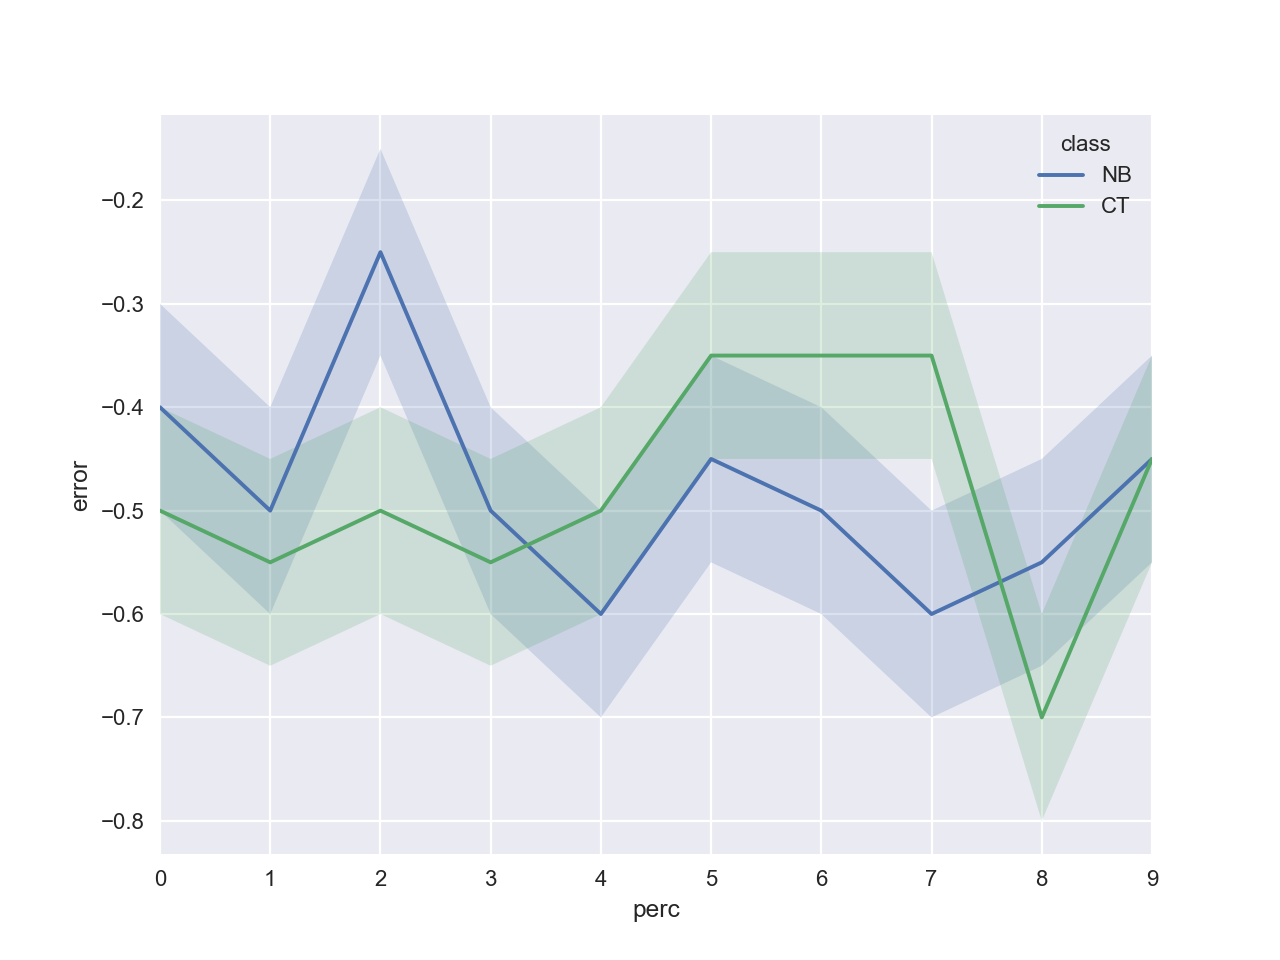

In [214]:
count = 0
for per in np.arange(10):
    for i in np.arange(20):
        errors.loc[count]=[per,'NB',i,np.random.randint(-1,1)]
        count+=1
        errors.loc[count]=[per,'CT',i,np.random.randint(-1,1)]
        count+=1
        
fig,ax = plt.subplots(figsize=(8,6))
sb.tsplot(data=errors,ax=ax,condition='class',time='perc',unit='rep',value='error')
plt.show()

In [207]:
errors

,perc,class,rep
0,0.0,NB,0.0
1,0.0,CT,0.0
2,0.0,NB,-1.0
3,0.0,CT,-1.0
4,0.0,NB,0.0
5,0.0,CT,0.0
6,0.0,NB,-1.0
7,0.0,CT,-1.0
8,0.0,NB,-1.0
9,0.0,CT,-1.0


<IPython.core.display.Javascript object>


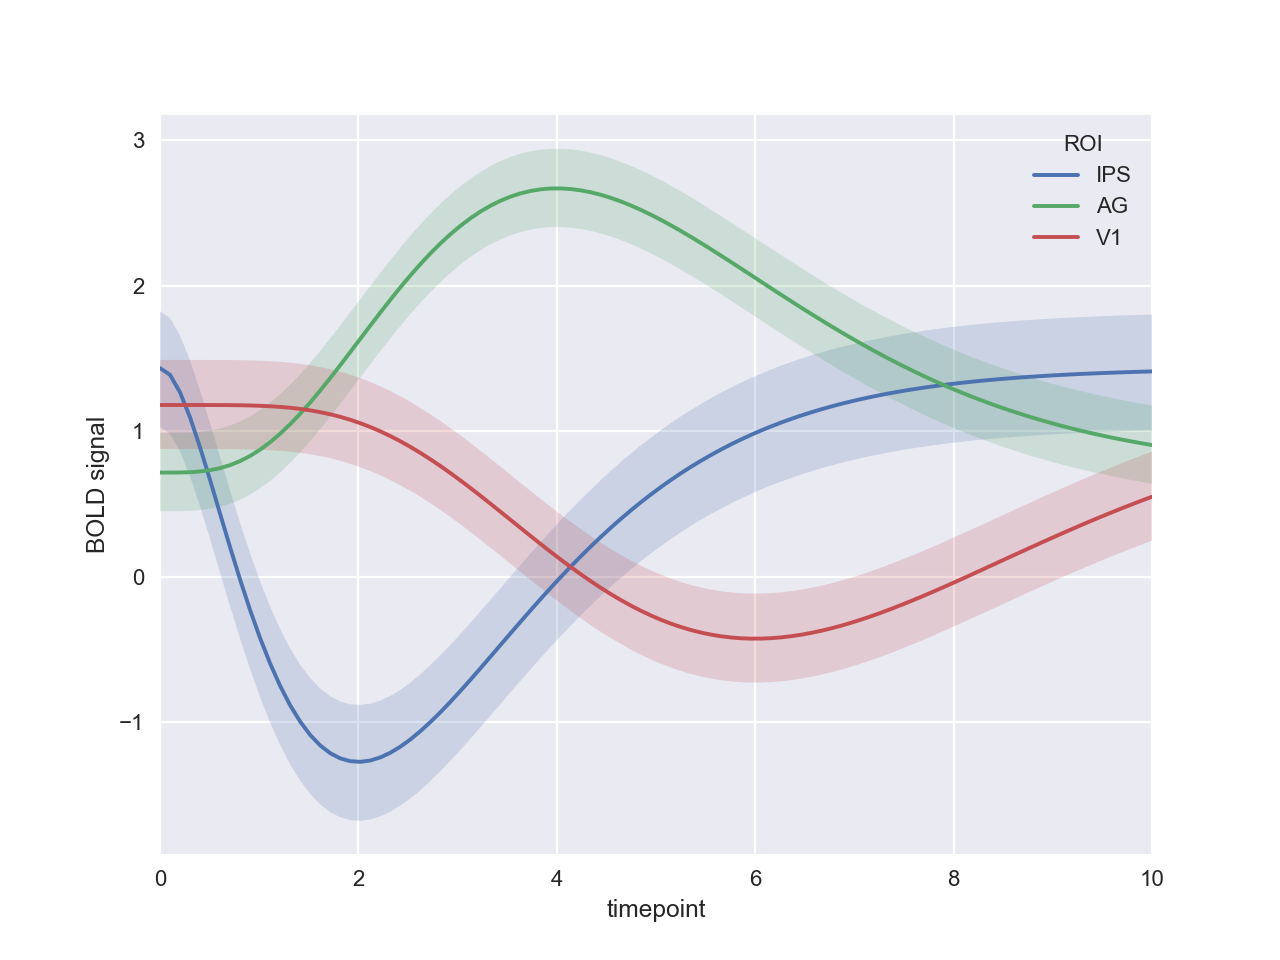

In [212]:
fig,ax = plt.subplots(figsize=(8,6))
sb.tsplot(data=gammas,ax=ax,condition='ROI',time='timepoint',unit='subject',value='BOLD signal')
plt.show()

In [211]:
gammas

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
5,0.0,IPS,5,-0.073709
6,0.0,IPS,6,3.542734
7,0.0,IPS,7,0.080169
8,0.0,IPS,8,1.547083
9,0.0,IPS,9,2.827153
